In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm 
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
ds = xr.open_dataset(r'../data/amazon2.nc')

In [32]:
#define the radious of the earth
A = 6371.0e3

u=ds.uo.isel(time=0)
v=ds.vo.isel(time=0)

#dy,dx, dz gradient 
dy = np.deg2rad(ds.latitude.shift(latitude=-1) - ds.latitude) * A
dx = (
    np.deg2rad(ds.longitude.shift(longitude=-1) - ds.longitude) * A
    * np.cos(np.deg2rad(ds.latitude)))
dz = (ds.depth.shift(depth=-1) - ds.depth)

#dudx middle point instead of corners of the square
dudx = (u.shift(longitude=-1) - u) / dx
dudx = (dudx.shift(latitude=-1) + dudx) / 2.0

#dvdy middle point instead of corners of the square
dvdy = (v.shift(latitude=-1) - v) / dy
dvdy = (dvdy.shift(longitude=-1) + dvdy) / 2.0

#lon,lat middle points of the square
lon = (ds.longitude.shift(longitude=-1) + ds.longitude) / 2
lat = (ds.latitude.shift(latitude=-1) + ds.latitude) / 2

#assign new coordinates with the middle point
dvdy = dvdy.assign_coords(longitude = lon, latitude = lat).isel(longitude=slice(None, -1),latitude=slice(None, -1))
dudx = dudx.assign_coords(longitude = lon, latitude = lat).isel(longitude=slice(None, -1),latitude=slice(None, -1))

#pre divergence
div_h = dudx + dvdy  # (nz, ny, nx)

# Paso 2: integración vertical de -div_h sobre z (ignorando niveles con NaN)
# dz = np.gradient(ds.depth)
w = np.full_like(div_h, np.nan)
nz, ny, nx = div_h.shape

In [35]:
# Asegura que las dimensiones están en orden (z, y, x)
div_h = div_h.transpose("depth", "latitude", "longitude")
dz = dz.transpose("depth")  # si es 1D

# Broadcast dz a 3D si es necesario
if dz.ndim == 1:
    dz = dz.broadcast_like(div_h)

# Multiplica para obtener los términos a integrar
integrand = -div_h * dz

# Máscara acumulativa: para cortar cuando hay NaN en div_h
mask = integrand.notnull()
mask_cum = mask.cumsum("depth") == np.arange(1, mask.sizes["depth"] + 1)[:, None, None]

# Aplicar máscara y hacer cumsum
w = integrand.where(mask_cum).cumsum("depth", skipna=True)

# Asignar nombre y atributos
w.name = "w"
w.attrs["units"] = "m/s"
w.attrs["long_name"] = "Vertical velocity integrated from divergence"


In [43]:
w = w.where(w != 0)
w

<xarray.DataArray 'w' (depth: 50, latitude: 176, longitude: 198)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 2.60137608e-06,  1.95282564e-06,  8.88412785e-07, ...,
          3.86273229e-07,  4.91604453e-07,  3.85030717e-07],
        [ 1.73226863e-06,  2.05028732e-06,  1.85084150e-06, ...,
         -3.13610080e-08,  4.89201341e-07,  7.98423059e-07],
        [ 4.86772706e-07,  1.00802049e-06,  1.42639067e-06, ...,
         -3.81380602e-07,  3.57543364e-08,  5.55106681e-07]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
          9.50665562e-05, -2.50519864e-04, -1.42067962e-04],
        [ 7.39594107e-04, -7.58548907e-04, -5.08390658e-05, ...,
          5.20825997e-05, -3.27738002e-04, -4.06497566e-06],
        [ 7.52631633e-04, -7.53855566e-04, -1.83502896e-04, ...,
         -4.45090060e-04,  2.12963379e-04,  9.42537736e-06]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-3.17820755e-04, -4.88319900e-04, -1.16477022e-05, ...,
          9.50665562e-05, -2.50519864e-04, -1.42067962e-04],
        [ 7.39594107e-04, -7.58548907e-04, -5.08390658e-05, ...,
          5.20825997e-05, -3.27738002e-04, -4.06497566e-06],
        [ 7.52631633e-04, -7.53855566e-04, -1.83502896e-04, ...,
         -4.45090060e-04,  2.12963379e-04,  9.42537736e-06]]],
      dtype=float32)
Coordinates:
    time       datetime64[ns] 2021-06-01
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 -3.625 -3.542 -3.458 ... 10.79 10.88 10.96
  * longitude  (longitude) float32 -57.71 -57.62 -57.54 ... -41.46 -41.37 -41.29
Attributes:
    units:      m/s
    long_name:  Vertical velocity integrated from divergence

## Plot

In [44]:
u=ds.uo.isel(time=0,longitude=slice(98,100),latitude=slice(98,100))
v=ds.vo.isel(time=0,longitude=slice(98,100),latitude=slice(98,100))
w1=w.isel(longitude=slice(98,100),latitude=slice(98,100))

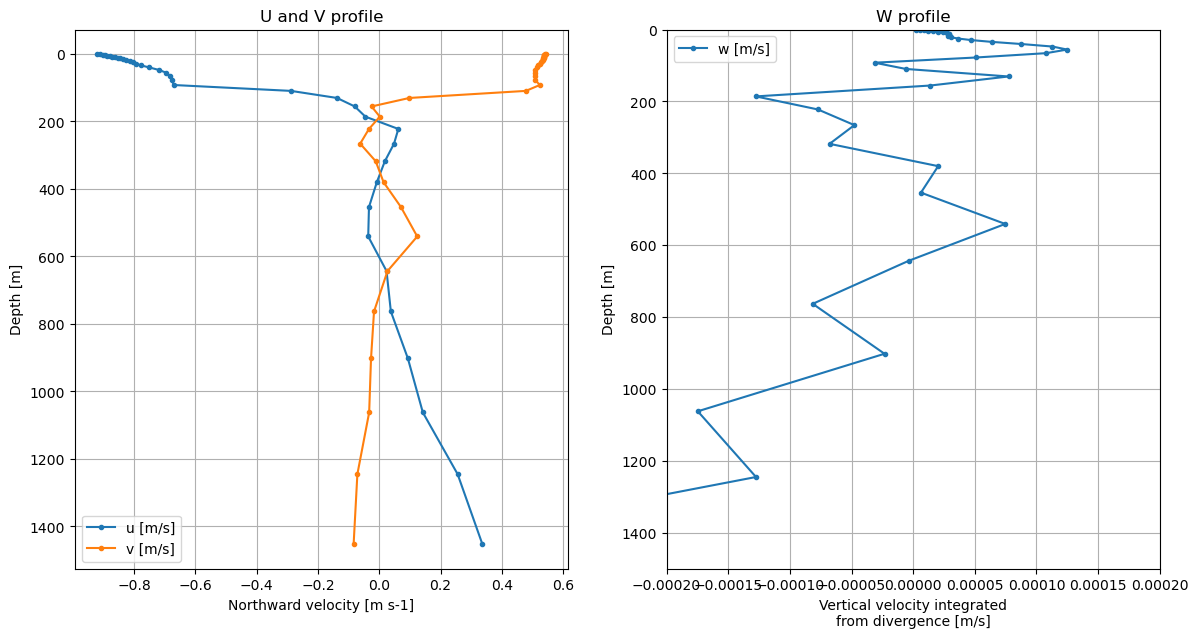

In [53]:
fig,ax = plt.subplots(1,2,figsize=(14,7))

u.isel(longitude=1,latitude=1).plot(y='depth',marker='.',label='u [m/s]',ax=ax[0])
v.isel(longitude=1,latitude=1).plot(y='depth',marker='.', label='v [m/s]',ax=ax[0])
ax[0].invert_yaxis()
ax[0].grid('minor')
ax[0].legend()
ax[0].set_title("U and V profile")

w1.isel(longitude=1,latitude=1).plot(y='depth',marker='.', label='w [m/s]',ax=ax[1])
ax[1].set_ylim(0,1500)
ax[1].set_xlim(-0.0002,0.0002)
ax[1].invert_yaxis()
ax[1].grid('minor')
ax[1].legend()
ax[1].set_title("W profile")

plt.legend()

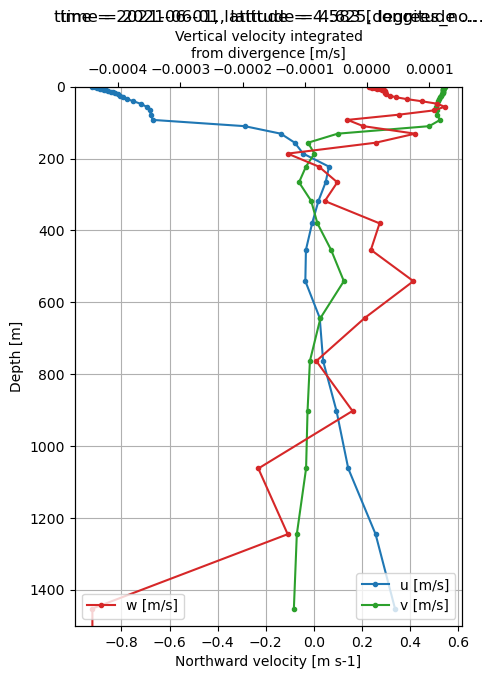

In [51]:
fig, ax = plt.subplots(figsize=(5, 7))

# Eje inferior: u y v
u.isel(longitude=1, latitude=1).plot(
    y='depth', marker='.', label='u [m/s]', ax=ax, color='tab:blue'
)
v.isel(longitude=1, latitude=1).plot(
    y='depth', marker='.', label='v [m/s]', ax=ax, color='tab:green'
)

ax.set_ylim(0,1500)
ax.invert_yaxis()
ax.grid('minor')
ax.legend(loc='lower right')
# ax.set_title("Profiles of u, v and w")

# Eje superior: w
ax2 = ax.twiny()
w1.isel(longitude=1, latitude=1).plot(
    y='depth', marker='.', label='w [m/s]', ax=ax2, color='tab:red'
)

# Ejes bien alineados
# ax2.set_xlabel("w [m/s]")
ax2.legend(loc='lower left')

In [50]:
df = pd.DataFrame({
    "depth [m]": ds.depth.data,
    "u [m/s]": u.isel(longitude=1, latitude=1).data,
    "v [m/s]": v.isel(longitude=1, latitude=1).data,
    "w[m/s]": w1.isel(longitude=1, latitude=1).data,
})
df

,depth [m],u [m/s],v [m/s],w[m/s]
0,0.494025,-0.920438,0.542619,0.000003
1,1.541375,-0.910062,0.540178,0.000006
2,2.645669,-0.900906,0.538957,0.000009
3,3.819495,-0.893582,0.538347,0.000012
4,5.078224,-0.886868,0.537736,0.000016
5,6.440614,-0.879543,0.537736,0.000020
6,7.929560,-0.871609,0.537126,0.000024
7,9.572997,-0.863063,0.537126,0.000027
8,11.405000,-0.853908,0.536515,0.000029
9,13.467140,-0.844752,0.535905,0.000029


### Next steps
* Put the u,v in the corners and the w in the middle, for this I need the z in the middle
* Find a way to delete the bottom values as it only repeats the last value
* we are close to finding W in a clean and fast way :D